In [1]:
import os
num_threads = "8"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [2]:
# autograd, pot, gwot, pykeops, pathos, dcor
import matplotlib.pyplot as plt
import torch

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from torch.autograd import grad, Variable
import autograd
import autograd.numpy as np
import copy
import scipy as sp
from scipy import stats
from sklearn import metrics
import sys
import ot
from gwot import models
import sim
import gwot.bridgesampling as bs


sys.path.append("fig1_batch")
import importlib
import models
import pred_models
import random

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)
device

device(type='cpu')

In [4]:
PLT_CELL = 2.5

In [5]:
# set random seed
SRAND = 0
torch.manual_seed(SRAND)
np.random.seed(SRAND)

In [6]:
dim = 4
sim_steps = 250 # number of steps to use for Euler-Maruyama method
T = 10 # number of timepoints
t_final = 2.25 # simulation run on [0, t_final]


def Psi(x, t, dim = dim):
    velocity = -np.array([x[:, 2],
                          x[:, 3],
                          np.zeros_like(x[:, 0]),
                          np.zeros_like(x[:, 0])
                          ]).T
    velocity[len(x)//2::, 1] *= -1
    return velocity
dPsi = Psi
Xi = lambda x, t: np.zeros_like(x)


D = 0.0005 # diffusivity
def ic_func(N, d):
    init = np.zeros((N, d))
    init[:, 2] = 4 # x velocity
    init[:, 3] = 4 # y velocity
    init[:, 0] = -4

    init[:, 1] = 4
    init[:N//2, 1] = -4

    return np.random.randn(N, d)*2*D + init

branching_rate = lambda x: 0*x[:, 0]

In [7]:
M = 50
N_vals = [32, 32]
N0 = 32
# setup simulation object
sims_all = [sim.Simulation(V = dPsi, dV = dPsi, Xi=Xi, birth_death = False, 
                          N = np.array([N0, ] + [N, ]*(T-2) + [N0, ]),
                          T = T, 
                          d = dim, 
                          D = D, 
                          t_final = t_final, 
                          ic_func = ic_func, 
                          pool = None) for N in N_vals]

# sample from simulation
for s in sims_all:
    s.sample(steps_scale = int(sim_steps/s.T));

In [8]:
sim_gt = copy.deepcopy(sims_all[0])
sim_gt.N = np.array([500, ]*T)
sim_gt.sample(steps_scale = int(sim_steps/sims_all[0].T));

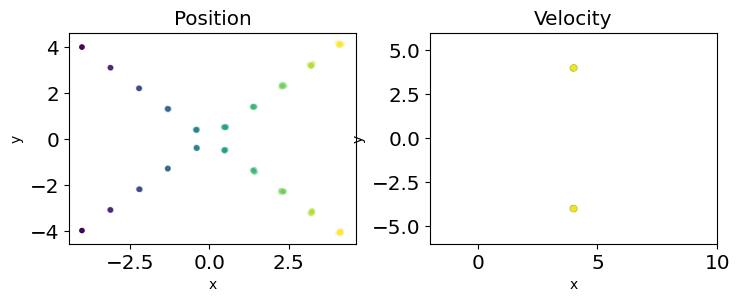

In [9]:
# plot samples
i = 0
plt.figure(figsize = (3*PLT_CELL, 1.25*PLT_CELL))
plt.subplot(1, 2, 1)
plt.scatter(sims_all[i].x[:, 0], sims_all[i].x[:, 1], s=8, alpha=0.15, c = sims_all[i].t_idx)
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Position")
plt.subplot(1, 2, 2)
plt.scatter(sims_all[i].x[:, 2], sims_all[i].x[:, 3], s=8, alpha=0.15, c = sims_all[i].t_idx)
plt.scatter(sims_all[i].x[:, 2], -sims_all[i].x[:, 3], s=8, alpha=0.15, c = sims_all[i].t_idx)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-2, 10); plt.ylim(-6, 6)
plt.title("Velocity")
plt.tight_layout()

In [10]:
importlib.reload(models)
importlib.reload(pred_models)
torch.set_num_threads(8)

In [11]:
lamda_reg = .05
lamda_cst = 0.2
sigma_cst = 2.0/2
hid_weight = 5
sinkhorn_iters = 250
eta_final = 0.005
sigma_final = 0.5
temp_init = 100
temp_ratio = (1/5)**(1/5000)


s = sims_all[0]
obs_idx = 2 # How many variables are observed (always the first ones in the index)
dt = t_final/T

forwardMap1 = torch.tensor([
    [1., 0., 0., 0.],
    [0., 1., 0., 0.],
    [dt/.8, 0., 1., 0.],
    [0., dt/.8, 0, 1.],
    ],device=device)
backwardMap1 = torch.tensor([
    [1., 0., 0., 0.],
    [0., 1., 0., 0.],
    [-dt/.8, 0., 1., 0.],
    [0., -dt/.8, 0, 1.],
    ],device=device)

#Make forward/backward maps a class
class predictionMap():
    def forward(self,x):
        return x @ forwardMap1

        
    def backward(self,x):
        return x @ backwardMap1
    
# pred = predictionMap() #If don't want to do prediction, can set to None
pred = predictionMap()
g = lambda x: x[:, 0:obs_idx] # observation function

fitType = 'Sinkhorn'
models_all = [pred_models.TrajLoss(pred, g, torch.randn(T, M, dim, device = device),
                        torch.tensor(s.x[:], device = device), obs_idx,
                        torch.tensor(s.t_idx, device = device), 
                        dt = t_final/T, tau = D, sigma = None, M = M,
                        lamda_reg = lamda_reg, lamda_cst = lamda_cst, sigma_cst = sigma_cst, hid_weight = hid_weight,
                        branching_rate_fn = None,
                        sinkhorn_iters = 500, device = device,fitType=fitType,warm_start = True),
              models.TrajLoss(torch.randn(T, M, dim, device = device),
                        torch.tensor(s.x[:], device = device), dim,
                        torch.tensor(s.t_idx, device = device), 
                        dt = t_final/T, tau = D, sigma = None, M = M,
                        lamda_reg = lamda_reg, lamda_cst = lamda_cst, sigma_cst = sigma_cst,
                        branching_rate_fn = None,
                        sinkhorn_iters = 500, device = device,warm_start = True)
                        ]

In [12]:
n_iters = 1000
outputs_all = [pred_models.optimize(models_all[0], n_iter = n_iters, eta_final = eta_final, tau_final = D, sigma_final = sigma_final, N = M, temp_init = temp_init, temp_ratio = temp_ratio, dim = dim, tloss = models_all[0], print_interval = 50,
                                    inspect_dynamics=True),
               models.optimize(models_all[1], n_iter = n_iters, eta_final = eta_final, tau_final = D, sigma_final = sigma_final, N = M, temp_init = temp_init, temp_ratio = temp_ratio, dim = dim, tloss = models_all[1], print_interval = 50)]


Iteration 0, Loss = -24.782, Primal loss = -24.582, Avg. iters = 499.000, eta = 0.500, temp = 100.000, Pred x vel avg. = 0.002, Pred y vel avg. = -0.014
Iteration 50, Loss = -30.731, Primal loss = -30.422, Avg. iters = 176.111, eta = 0.492, temp = 98.403, Pred x vel avg. = 0.837, Pred y vel avg. = 0.009
Iteration 100, Loss = -30.845, Primal loss = -30.487, Avg. iters = 77.000, eta = 0.484, temp = 96.832, Pred x vel avg. = 1.296, Pred y vel avg. = -0.007
Iteration 150, Loss = -30.658, Primal loss = -30.292, Avg. iters = 36.444, eta = 0.476, temp = 95.286, Pred x vel avg. = 1.476, Pred y vel avg. = 0.006
Iteration 200, Loss = -30.411, Primal loss = -30.052, Avg. iters = 33.778, eta = 0.469, temp = 93.765, Pred x vel avg. = 1.553, Pred y vel avg. = 0.007
Iteration 250, Loss = -30.160, Primal loss = -29.802, Avg. iters = 58.222, eta = 0.461, temp = 92.268, Pred x vel avg. = 1.585, Pred y vel avg. = 0.023
Iteration 300, Loss = -29.906, Primal loss = -29.556, Avg. iters = 42.778, eta = 0.454

Text(0.5, 1.0, 'Objective: primal')

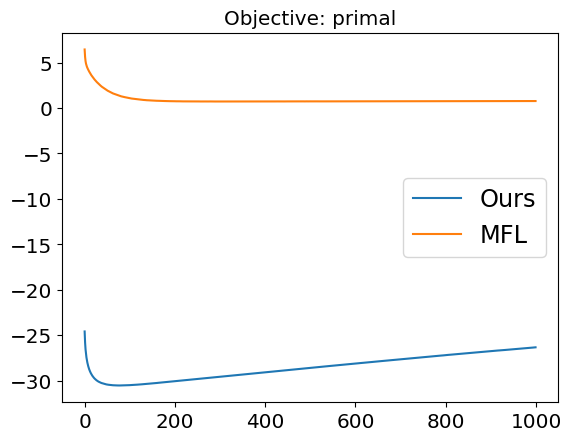

In [13]:
plt.plot(np.vstack([o[1] for o in outputs_all]).T)
plt.legend(["Ours", "MFL"])
plt.title("Objective: primal")

In [14]:
u = np.full(dim, 1); u[2:] = 0
u = u/np.linalg.norm(u)
N_paths_gt = 250
N_paths = 50
paths_gt = sim_gt.sample_trajectory(steps_scale = int(sim_steps/sim_gt.T), N = N_paths_gt)

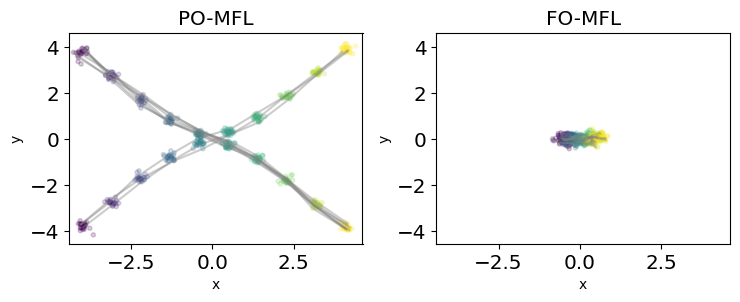

In [15]:
N_paths = 10

plt.figure(figsize = (3*PLT_CELL, 1.25*PLT_CELL))
for (i, m) in enumerate(models_all):
    plt.subplot(1, len(N_vals), i+1)
    with torch.no_grad():
        paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = m.x.cpu().numpy(), 
                            get_gamma_fn = lambda i : m.loss_reg.ot_losses[i].coupling().cpu(), num_couplings = T-1)
        plt.plot(paths[:, :, 0].T, paths[:, :, 1].T, color = 'grey', alpha =0.4);
        plt.scatter(m.x.reshape(-1, dim)[:, 0].cpu(), m.x.reshape(-1, dim)[:, 1].cpu(), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.2, marker = ".")
    plt.xlabel("x"); plt.ylabel("y")
    if i == 1:
        plt.title("FO-MFL")
    else:
        
        plt.title("PO-MFL")
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max)
plt.tight_layout()

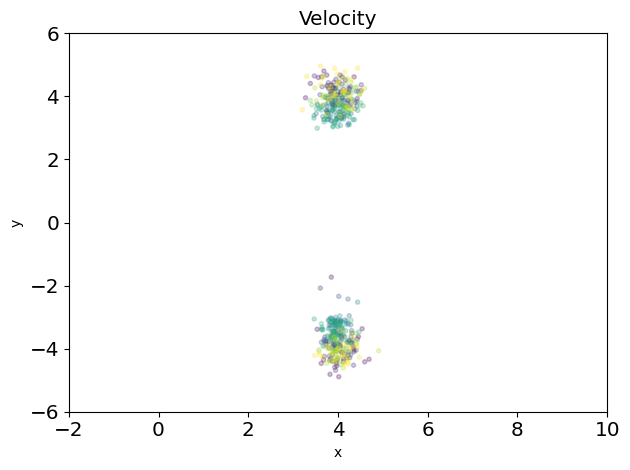

In [16]:
N_paths = 5
model = models_all[0]
# plt.figure(figsize = (3*PLT_CELL, 1.2*PLT_CELL))

m = models_all[0]
titles = ["Position", "Velocity"]

for i in [1]:
    # plt.subplot(1, len(N_vals), i+1)
    with torch.no_grad():
        paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = m.x.cpu().numpy(), 
                            get_gamma_fn = lambda i : m.loss_reg.ot_losses[i].coupling().cpu(), num_couplings = T-1)
        
        
        if i == 0:
            plt.scatter(m.x.reshape(-1, dim)[:, 2 * i].cpu(), m.x.reshape(-1, dim)[:, 2* i + 1].cpu(), c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25, marker = ".")
        else:
            plt.scatter(m.x.reshape(-1, dim)[:, 2 * i].cpu() * 2/0.8, m.x.reshape(-1, dim)[:, 2* i + 1].cpu() * 2/0.8, c = np.kron(np.arange(T), np.ones(M)), alpha = 0.25, marker = ".")
    plt.xlabel("x"); plt.ylabel("y")

    if i == 1:
        plt.xlim(-2, 10); plt.ylim(-6, 6)
    plt.title(titles[i])

plt.tight_layout()